In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin


# Baseline Model

In [2]:
def plot_PR_curve(y_labels, y_preds, y_limit=1.0):
    '''Plot average precision chart'''
      
    from sklearn.metrics import precision_recall_curve, average_precision_score
    import matplotlib.pyplot as plt
    from funcsigs import signature

    average_precision = average_precision_score(y_labels, y_preds)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    precision, recall, _ = precision_recall_curve(y_labels, y_preds)
    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
    plt.figure(figsize=(10, 10))
    plt.step(recall, precision, color='r', alpha=0.4, where='post')
    plt.fill_between(recall, precision, alpha=0.4,
                         color='r', **step_kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, y_limit])
    plt.xlim([0.0, 1.0])
    plt.title( '2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

def plot_roc_auc_curve(y_labels, y_preds):
    import sklearn.metrics as metrics
    # calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, _ = metrics.roc_curve(y_labels, y_preds)
    roc_auc = metrics.auc(fpr, tpr)

    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


In [3]:
class ItemSelector(BaseEstimator, TransformerMixin):
    """
    Transform text features
    """

    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None, *parg, **kwarg):
        return self

    def transform(self, X):
        # NULL replacement
        return X[self.key].fillna('NULL').astype(str)


class NullCheck(BaseEstimator, TransformerMixin):
    """
    Transform text features
    """

    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None, *parg, **kwarg):
        return self

    def transform(self, X):
        # NULL replacement
        return X[self.key].isnull()*1

In [4]:
class LogisticRegressionCustom():
    def __init__(self, base_model):
        self.base_model = base_model
        self.models = []

    def fit(self, X_train, y_train, n_splits=5):
        cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        y_oof = np.zeros(y_train.shape[0])
        for train_ids, valid_ids in cv.split(X_train):
            model = self.base_model(C=0.7,  fit_intercept=False, penalty='l2',
                                       random_state=42, class_weight='balanced', solver='lbfgs')
            model.fit(X_train[train_ids], y_train[train_ids])
            y_oof[valid_ids] = model.predict_proba(X_train[valid_ids])[:, 1]
            auc_train = round(roc_auc_score(y_train[train_ids], model.predict_proba(X_train[train_ids])[:, 1]), 3)
            auc_test = round(roc_auc_score(y_train[valid_ids], y_oof[valid_ids]), 3)
            print(f'Train AUC: {auc_train}, Test AUC: {auc_test}')
            self.models.append(model)

        self.oof_predictions = y_oof
        self.labels = y_train
            
        print('Out of Fold AUC on full test data: {}'.format(round(roc_auc_score(y_train, y_oof), 3)))


    def predict_proba(self, X):
        y = np.zeros(X.shape[0])

        for m in self.models:
            y += m.predict_proba(X)[:, 1] / len(self.models)
        return y

In [5]:
df = pd.read_csv(r'data/web_dataset.csv')
df.head()


,WEB_TEXT,TITLE,DESCRIPTION,KEYWORDS,TARGET
0,Search Search Made with Organic Corn Great Tas...,Home - Garden of Eatin',NaN,NaN,restaurant
1,Find Your Cook Out Locations Employment Contac...,NaN,NaN,NaN,restaurant
2,"1/8 Go 4 Food is a Michelin Award winning, NBC...",Home 首頁 | go4food,NaN,NaN,restaurant
3,NaN,NaN,Welcome to Flow Restaurant & Lounge: A Mendoci...,"flow, restaurant, mendocino, mendo, california...",restaurant
4,NaN,Marathon Brand - Home | Gas Stations & Other B...,Welcome to Marathon Petroleum's Brand site. He...,NaN,restaurant


In [6]:
df[df['TITLE'].isnull() &df['KEYWORDS'].isnull() & df['DESCRIPTION'].isnull()]

,WEB_TEXT,TITLE,DESCRIPTION,KEYWORDS,TARGET
1,Find Your Cook Out Locations Employment Contac...,NaN,NaN,NaN,restaurant
9,As a family owned and operated business Harbor...,NaN,NaN,NaN,restaurant
13,"Cleggan, Clifden, Connemara, Co. Galway, Irela...",NaN,NaN,NaN,accommodation
14,Book Online Arrival Date: Nights: Best rate gu...,NaN,NaN,NaN,accommodation
16,541-423-8888 Select Page Bobbio's Pizza Strong...,NaN,NaN,NaN,restaurant
...,...,...,...,...,...
3365,Domain is for sale,NaN,NaN,NaN,restaurant
3366,Domain is for sale,NaN,NaN,NaN,restaurant
3367,Domain is for sale,NaN,NaN,NaN,restaurant
3368,Domain is for sale,NaN,NaN,NaN,restaurant


In [7]:
df = df[~(df['TITLE'].isnull() &df['KEYWORDS'].isnull() & df['DESCRIPTION'].isnull())].reset_index(drop=True)

In [8]:
df[df['TITLE'].isnull() &df['KEYWORDS'].isnull() & df['DESCRIPTION'].isnull()]['WEB_TEXT'].value_counts().describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: WEB_TEXT, dtype: float64

In [9]:
df['TARGET'].value_counts(dropna=False)

restaurant       2120
accommodation     206
retsaurant          2
acommodation        1
Name: TARGET, dtype: int64

In [10]:
df.shape[0]

2329

In [11]:
df['TARGET'] = df['TARGET'].map({'restaurant': 'restaurant',
                                 'retsaurant': 'restaurant',
                                 'accommodation': 'accommodation',
                                 'acommodation': 'accommodation',
                                })

df = df[df.TARGET.notnull()].reset_index(drop=True)

In [12]:
df.shape[0]

2329

In [13]:
columns = ['WEB_TEXT', 'TITLE', 'DESCRIPTION', 'KEYWORDS']

In [14]:
df['BINARY_TARGET'] = (df['TARGET'] != 'restaurant')*1


In [15]:
df['BINARY_TARGET'].mean()


0.0888793473593817

In [16]:
for column in columns:
    print(f'Max sentence length for column: {column}')
    print(df[column].str.len().max())

Max sentence length for column: WEB_TEXT
1237.0
Max sentence length for column: TITLE
168.0
Max sentence length for column: DESCRIPTION
1791.0
Max sentence length for column: KEYWORDS
9629.0


In [17]:
model = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features
                ('KEYWORDS', Pipeline([
                    ('selector', ItemSelector(key='KEYWORDS')),
                    ('tdidf', TfidfVectorizer(
                        ngram_range=(1, 3),
                        max_features=100
                    ),
                    )
                ])),
                ('WEB_TEXT', Pipeline([
                    ('selector', ItemSelector(key='WEB_TEXT')),
                    ('tdidf', TfidfVectorizer(
                        ngram_range=(1, 3),
                        max_features=100
                    ),
                    )
                ])),
            ('TITLE', Pipeline([
                ('selector', ItemSelector(key='TITLE')),
                ('count', CountVectorizer(
                    ngram_range=(1, 2),
                    max_features=50)
                 )
            ])),


            ('DESCRIPTION', Pipeline([
                ('selector', ItemSelector(key='DESCRIPTION')),
                ('count', CountVectorizer(
                    token_pattern='.+',
                    max_features=50)
                 )
            ])),

             ('TITLE_NULL', Pipeline([
                ('selector', NullCheck(key='TITLE')),
                ('ohe', OneHotEncoder(handle_unknown='ignore'))
            ])),

             ('KEYWORDS_NULL', Pipeline([
                ('selector', NullCheck(key='KEYWORDS')),
                ('ohe', OneHotEncoder(handle_unknown='ignore'))
            ])),
        ],

        # weight components in FeatureUnion
        transformer_weights={
            'KEYWORDS': 0.9,
            'TITLE': 0.5,
            'WEB_TEXT': 0.5,
            'DESCRIPTION': 0.5,
            'TITLE_NULL': 5,
            'KEYWORDS_NULL': 5,
        },
    )),
    ('logreg', LogisticRegressionCustom(LogisticRegression))])

model.fit(df[columns], df.BINARY_TARGET)


ValueError: blocks[0,:] has incompatible row dimensions. Got blocks[0,4].shape[0] == 1, expected 2329.

In [ ]:
from joblib import dump, load
dump(model, '../model/baseline_model.joblib')

['../model/baseline_model.joblib']

# Define best threshold

Average precision-recall score: 0.73


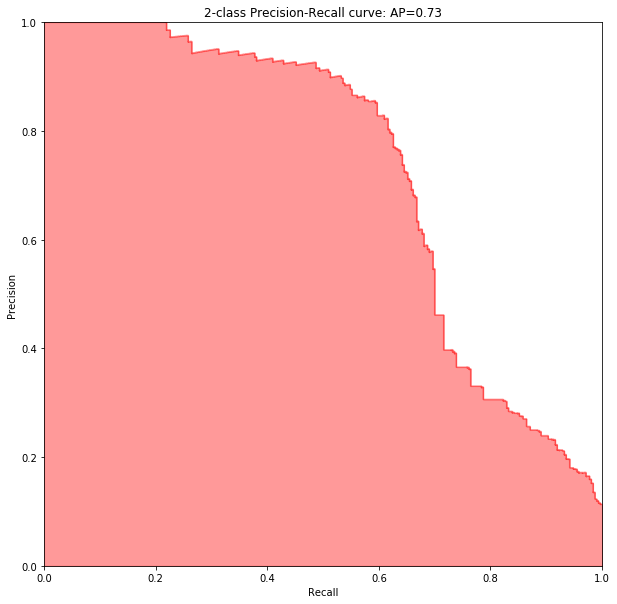

In [ ]:
plot_PR_curve(model['logreg'].labels, model['logreg'].oof_predictions)

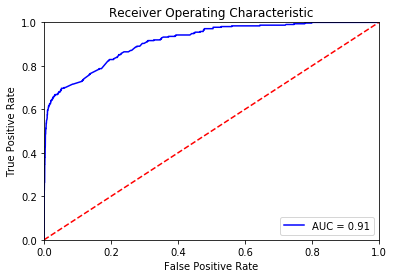

In [ ]:
plot_roc_auc_curve(model['logreg'].labels, model['logreg'].oof_predictions)

# Simple Feature Engineering

In [ ]:
def check_null_categories(column_name):
    df[f'{column_name}_NULL'] = df[f'{column_name}'].isnull()*1
    return df.groupby(f'{column_name}_NULL')['BINARY_TARGET'].mean()


In [ ]:
check_null_categories('WEB_TEXT')

WEB_TEXT_NULL
0    0.090267
1    0.094385
Name: BINARY_TARGET, dtype: float64

In [ ]:
check_null_categories('TITLE')

TITLE_NULL
0    0.056916
1    0.122471
Name: BINARY_TARGET, dtype: float64

In [ ]:
check_null_categories('DESCRIPTION')


DESCRIPTION_NULL
0    0.096465
1    0.087500
Name: BINARY_TARGET, dtype: float64

In [ ]:
check_null_categories('KEYWORDS')

KEYWORDS_NULL
0    0.126021
1    0.081353
Name: BINARY_TARGET, dtype: float64